# Setup
Lets start by getting all the boiler plate out of the way

In [1]:
import os

#del os.environ['PYSPARK_SUBMIT_ARGS']
os.environ['PYSPARK_SUBMIT_ARGS'] = '--jars /Users/benjarman/Downloads/RedshiftJDBC41-1.2.8.1005.jar,/Users/benjarman/Development/java/lib/postgresql-42.1.4.jar --master local[2] pyspark-shell'
#os.environ['SPARK_HOME'] = '/Users/benjarman/Development/spark/2.2.0'

import pyspark
from pyspark import SQLContext
from pyspark.sql import SparkSession

import pandas as pd
from pyspark.sql.functions import *
from pyspark.sql.types import *

data_dir="/Users/benjarman/Development/SparkIpython/data"

In [2]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt

In [3]:
sql = SparkSession.builder.master("local").appName("wm").getOrCreate()

# Reading the data
Next we can load all the data into a spark dataframe.

In [4]:
#TODO turn this cell and the next one into a list comprehension 
users = sql.read.option("inferSchema", "true").option("header", "true").csv(data_dir + "/users.txt.bz2")
events = sql.read.option("inferSchema", "true").option("header", "true").csv(data_dir + "/events.txt.bz2")
store_items = sql.read.option("inferSchema", "true").option("header", "true").csv(data_dir + "/store_items.txt.bz2")
stores = sql.read.option("inferSchema", "true").option("header", "true").csv(data_dir + "/stores.txt.bz2")
promotions = sql.read.option("inferSchema", "true").option("header", "true").csv(data_dir + "/promotions.txt.bz2")

In [5]:
data_sets = [
    ("public.users", users), 
    ("public.events", events), 
    ("public.store_items", store_items), 
    ("public.stores", stores), 
    ("public.promotions",promotions)
]

# Gonna explore some schema issues.
It seems like the load function is having issues with the type of bit

In [6]:
users.toPandas().head()

,id,name,email,active,created_date
0,1,Jennifer Miller,nicole10@lowe.biz,True,2017-05-30 02:08:57
1,2,Justin White,ricejacob@yahoo.com,False,2017-01-31 05:52:37
2,3,Patrick Henry,douglas20@reynolds.com,False,2017-07-02 17:55:16
3,4,Robert Orr,benjamin13@spencer-buckley.com,False,2017-08-07 20:03:38
4,5,Robin Phillips,cassandra33@yahoo.com,True,2017-03-25 18:14:57


In [7]:
users.schema

StructType(List(StructField(id,IntegerType,true),StructField(name,StringType,true),StructField(email,StringType,true),StructField(active,BooleanType,true),StructField(created_date,TimestampType,true)))

In [8]:
#Doing a quick test to see if this works
data_sets[0] = ("users", users.withColumn("active", expr('cast(active as int)')))

# Next lets load the data into redshift

In [9]:
#Commented out because I want to be able to click run all cells
#and don't want to have it stop because of the exception, but
#i'm not done here.
#mode = "overwrite"
#url = "jdbc:redshift//sample-data-cluster.cuzjjz7ia71a.us-west-2.redshift.amazonaws.com:5439/test?Profile=codetest"
#properties = {
#    "user": "master",
#    "password": "Fy7W4C^JwAWe&lKb",
#    "driver": "com.amazon.redshift.jdbc.Driver"
#}

#for dat in data_sets:
#    dat[1].write.jdbc(url=url, table=dat[0], mode=mode, properties=properties)

# Alright, well I can't get the data to load to this redshift cluster for the life of me. Lets see what we can do without it.

I'm gonna start by exploring the data sets so I know what I have to work with

In [10]:
events.toPandas().head()

,id,event_date,event_type,geography_id,store_id,store_item_id,promotion_id,user_id
0,1,2017-05-03 10:04:27,store - viewed details page,6,32586.0,None,NaN,NaN
1,2,2017-08-08 02:57:18,user - viewed promotion admin page,8,NaN,None,NaN,59117.0
2,3,2017-08-26 06:46:45,user - viewed store item admin page,2,NaN,None,NaN,48243.0
3,4,2017-05-17 05:25:06,user - viewed vendor admin page,6,NaN,None,NaN,345.0
4,5,2017-07-05 15:26:13,search - search term clicked,6,NaN,None,NaN,NaN


In [11]:
stores.toPandas().head()

,id,name,created_date,store_level
0,1,Ipsa quisquam eaque vel enim.,2017-02-22 10:01:27,4
1,2,Velit ducimus numquam accusamus facilis numquam.,2017-07-13 18:36:13,5
2,3,Aspernatur corporis voluptate itaque perferend...,2017-03-11 17:48:38,0
3,4,Quam hic vitae iure nemo.,2017-06-22 13:43:49,5
4,5,Vel velit ipsa possimus maiores.,2017-04-11 12:11:59,4


In [12]:
store_items.toPandas().head()

,id,name,store_id,active,created_date
0,1,Veniam eligendi dignissimos sint dolorem quam ...,49837,False,2017-02-24 04:53:30
1,2,Qui cupiditate optio esse nisi explicabo ducimus.,9551,False,2017-08-04 13:15:05
2,3,Nisi reprehenderit velit veritatis ad aut ipsa...,64585,True,2017-01-10 18:17:47
3,4,Quia nostrum illo sunt totam excepturi.,53008,True,2017-01-19 05:52:12
4,5,Nulla facilis nam neque.,18850,True,2017-05-29 01:30:26


In [13]:
users.toPandas().head()

,id,name,email,active,created_date
0,1,Jennifer Miller,nicole10@lowe.biz,True,2017-05-30 02:08:57
1,2,Justin White,ricejacob@yahoo.com,False,2017-01-31 05:52:37
2,3,Patrick Henry,douglas20@reynolds.com,False,2017-07-02 17:55:16
3,4,Robert Orr,benjamin13@spencer-buckley.com,False,2017-08-07 20:03:38
4,5,Robin Phillips,cassandra33@yahoo.com,True,2017-03-25 18:14:57


# Well I can't remember the exact challenge but lets explore the data and then come up with our own 

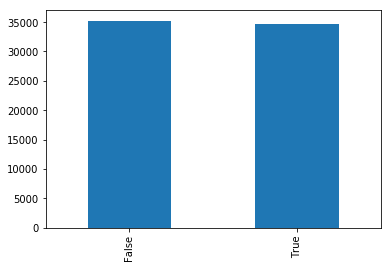

In [14]:
users_pd = users.toPandas()
pd.value_counts(users_pd['active'].values, sort=True).plot(kind="bar")

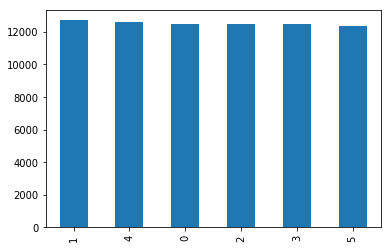

In [15]:
stores_pd = stores.toPandas()
pd.value_counts(stores_pd['store_level'].values, sort=True).plot(kind="bar")

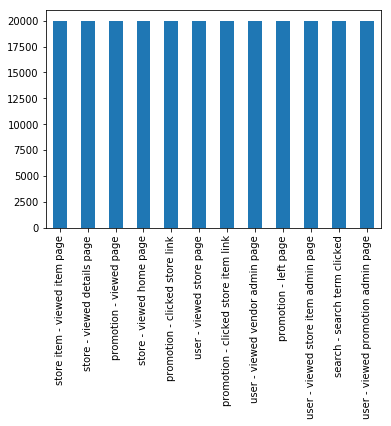

In [16]:
events_pd = events.toPandas()
events_pd['event_type'].value_counts().plot.bar()

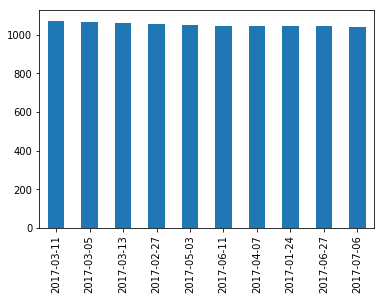

In [17]:
events_pd['just_date'] = events_pd['event_date'].dt.date
events_pd['just_date'].value_counts().head(10).plot.bar()

# Next Steps
Alright, this data is clearly generated, as stated and way to consistent to do anything fun with. That said this was not a data science challenge. Lets start by finding the 10 users with the most events. We will switch back to spark pretending that this is terabytes of data and the use pandas to display and plot it.

In [18]:
# So I need to do some exploration of the events table. For what ever reason user_id is a decimal.
events.schema

StructType(List(StructField(id,IntegerType,true),StructField(event_date,TimestampType,true),StructField(event_type,StringType,true),StructField(geography_id,IntegerType,true),StructField(store_id,IntegerType,true),StructField(store_item_id,StringType,true),StructField(promotion_id,IntegerType,true),StructField(user_id,IntegerType,true)))

k so it looks like pandas is doing that when we convert the spark sql df to and pandas df. We should be good to move forward

In [19]:
grouped = events.groupBy("user_id").agg( count("user_id") )
grouped = grouped.withColumnRenamed("count(user_id)", "count")
grouped.schema

StructType(List(StructField(user_id,IntegerType,true),StructField(count,LongType,false)))

In [20]:
sorted = grouped.sort( grouped['count'].desc() )
sorted.show()

+-------+-----+
|user_id|count|
+-------+-----+
|  29131|    8|
|  68290|    7|
|  21323|    7|
|  53401|    7|
|  37668|    7|
|  55583|    7|
|  20769|    7|
|  51567|    7|
|  49890|    6|
|  53209|    6|
|   9763|    6|
|  64317|    6|
|  69879|    6|
|  62330|    6|
|   1644|    6|
|  65452|    6|
|   6572|    6|
|  62839|    6|
|  53488|    6|
|  41393|    6|
+-------+-----+
only showing top 20 rows



array([[<matplotlib.axes._subplots.AxesSubplot object at 0x112567910>]], dtype=object)

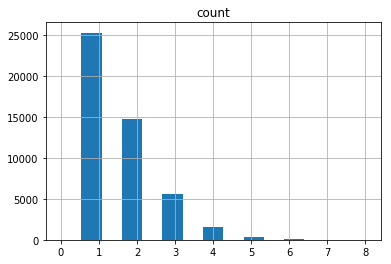

In [21]:
# So the fact that the top user is 8 events tells me that when we break it down by day its gonna be very sad.
# lets see what the distribution looks likes.
sorted.select('count').toPandas().hist(bins=15)

In [22]:
# So this is unrelated but I'm curious what the distribution is like for geography_id
grouped_ct = events.groupBy("geography_id").agg( count("geography_id") )
grouped_ct = grouped_ct.withColumnRenamed( "count(geography_id)", "count" )
sorted_ct = grouped_ct.sort( grouped_ct['count'].desc() )

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x116612390>]], dtype=object)

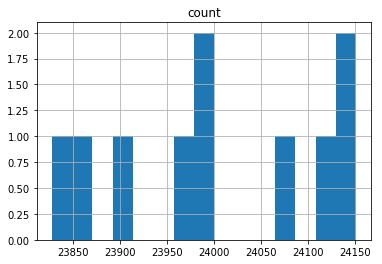

In [23]:
sorted_ct.select('count').toPandas().hist(bins=15)

^ This is interesting. I think I would def.. make geography_id our distribution key. That said I'm use to sharding on region, our distro key would heavely depend on data access paths.

# Now lets find the top users by day

In [24]:
#Before we do any aggregations we need to get rid of the timestamps
events = events.withColumn('event_date', events['event_date'].cast('date'))

In [25]:
events.toPandas().head()

,id,event_date,event_type,geography_id,store_id,store_item_id,promotion_id,user_id
0,1,2017-05-03,store - viewed details page,6,32586.0,None,NaN,NaN
1,2,2017-08-08,user - viewed promotion admin page,8,NaN,None,NaN,59117.0
2,3,2017-08-26,user - viewed store item admin page,2,NaN,None,NaN,48243.0
3,4,2017-05-17,user - viewed vendor admin page,6,NaN,None,NaN,345.0
4,5,2017-07-05,search - search term clicked,6,NaN,None,NaN,NaN


In [26]:
foo = events.groupBy(["user_id", "event_date"]).count()#.agg( count("user_id"), count("event_date") )

In [27]:
foo.sort( foo['count'].desc() ).show()

+-------+----------+-----+
|user_id|event_date|count|
+-------+----------+-----+
|   null|2017-03-05|  726|
|   null|2017-01-21|  714|
|   null|2017-08-24|  711|
|   null|2017-06-23|  709|
|   null|2017-02-14|  707|
|   null|2017-03-11|  701|
|   null|2017-06-11|  700|
|   null|2017-02-23|  700|
|   null|2017-03-22|  698|
|   null|2017-06-10|  697|
|   null|2017-07-24|  697|
|   null|2017-08-14|  697|
|   null|2017-06-26|  696|
|   null|2017-05-08|  695|
|   null|2017-05-03|  695|
|   null|2017-07-13|  695|
|   null|2017-05-28|  694|
|   null|2017-03-13|  694|
|   null|2017-02-22|  693|
|   null|2017-05-29|  693|
+-------+----------+-----+
only showing top 20 rows



In [28]:
# ^ It seems weird that there are so many null user_id's. 
# This does not seem right, lets look into it then filter them out.
events.where( col("user_id").isNull() ).show()

+---+----------+--------------------+------------+--------+-------------+------------+-------+
| id|event_date|          event_type|geography_id|store_id|store_item_id|promotion_id|user_id|
+---+----------+--------------------+------------+--------+-------------+------------+-------+
|  1|2017-05-03|store - viewed de...|           6|   32586|         null|        null|   null|
|  5|2017-07-05|search - search t...|           6|    null|         null|        null|   null|
|  6|2017-04-29|promotion - left ...|           6|    5595|         null|      151316|   null|
|  8|2017-06-08|promotion - viewe...|           8|   36547|         null|      177502|   null|
|  9|2017-03-05|promotion - click...|           1|   64494|         null|      184930|   null|
| 10|2017-01-28|store - viewed ho...|           1|   63733|         null|        null|   null|
| 11|2017-07-13|promotion - click...|           7|   60964|         null|      138892|   null|
| 12|2017-04-02|store item - view...|           1|

In [29]:
filtered_events = events.where( col("user_id").isNotNull() )
events_grouped_no_nulls = filtered_events.groupBy(["user_id", "event_date"]).count()

In [30]:
event_sdf = events_grouped_no_nulls.sort( events_grouped_no_nulls['count'].desc() )

In [31]:
event_sdf.toPandas().head()

,user_id,event_date,count
0,40907,2017-03-31,2
1,19101,2017-07-26,2
2,18500,2017-03-04,2
3,53456,2017-02-04,2
4,65674,2017-04-23,2


# Lets plot this
Based on the numbers in the cell above it's gonna be a sad graph,
But lets do it for kicks and gigles

In [32]:
event_sdf_pd = event_sdf.toPandas()

In [33]:
#Aright plotting this data makes very little since, but maybe all come back to it so i'm gonna leave these cells here
# I was trying to achieve grouped bar chart by date(desc) and then user event(desc) 

#bar = event_sdf_pd.reset_index().pivot(index='event_date', columns='user_id', values='count').fillna(0)
#baz = bar.loc[:, (bar != 0).any(axis=0)]
#baz.head(5)
#.plot(kind="bar")

In [34]:
#baz.head(50).plot(kind="bar")

# Gonna do a few more python examples then move on to some actual sql
1. Find the top event types
2. Find the top preforming stores

In [35]:
events.groupBy("event_type").count().toPandas()

,event_type,count
0,promotion - viewed page,20000
1,store item - viewed item page,20000
2,user - viewed store item admin page,20000
3,store - viewed details page,20000
4,search - search term clicked,20000
5,user - viewed vendor admin page,20000
6,promotion - clicked store link,20000
7,promotion - left page,20000
8,user - viewed promotion admin page,20000
9,promotion - clicked store item link,20000


Well thats not super exciting ^

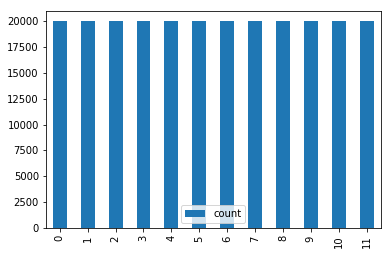

In [46]:
# Gonna quickly check what the distro looks like here
events.groupBy("event_type").count().toPandas().head(50).plot(kind="bar")

In [36]:
no_null_events = events.filter("store_id is not null")

In [37]:
counted_store_events = no_null_events.groupBy("store_id").count()

In [38]:
joined_store_stuff = counted_store_events.join(stores, counted_store_events.store_id == stores.id)

In [39]:
joined_store_stuff.show()

+--------+-----+-----+--------------------+-------------------+-----------+
|store_id|count|   id|                name|       created_date|store_level|
+--------+-----+-----+--------------------+-------------------+-----------+
|    5518|    4| 5518|Dolor blanditiis ...|2017-05-22 09:22:20|          3|
|   65408|    2|65408|Provident rerum a...|2017-08-08 09:55:41|          1|
|   72702|    4|72702|Maiores perferend...|2017-02-19 01:15:41|          5|
|   64822|    4|64822|Minus nobis conse...|2017-04-20 12:07:42|          4|
|   49717|    2|49717|Ducimus reprehend...|2017-01-13 07:29:36|          4|
|   22097|    1|22097|Molestiae possimu...|2017-02-09 20:09:09|          0|
|   73933|    2|73933|In aliquid quod s...|2017-08-17 22:09:08|          3|
|   63106|    3|63106|Alias neque ea ut...|2017-06-17 14:05:04|          2|
|   57693|    3|57693|Nostrum vero eos ...|2017-02-04 15:02:06|          1|
|   69042|    8|69042|Fugiat voluptatum...|2017-03-14 01:21:56|          2|
|   45341|  

In [40]:
# Now lets day we only wanted to see level 3 and greater and get the top ten
filtered_store_stuff = joined_store_stuff.filter("store_level > 2").sort( joined_store_stuff['count'].desc() )
filtered_store_stuff.show()

+--------+-----+-----+--------------------+-------------------+-----------+
|store_id|count|   id|                name|       created_date|store_level|
+--------+-----+-----+--------------------+-------------------+-----------+
|   64363|   11|64363|Voluptatibus eos ...|2017-05-28 19:24:06|          5|
|   57103|    9|57103|Suscipit debitis ...|2017-01-13 19:39:55|          3|
|    2851|    9| 2851|Sequi ullam delen...|2017-06-24 04:48:54|          5|
|   10667|    9|10667|Voluptates ipsam ...|2017-06-24 02:36:51|          5|
|   21306|    9|21306|Fugit ad nisi arc...|2017-06-01 19:00:22|          5|
|   14364|    9|14364|Fugit dolore expl...|2017-07-12 06:24:34|          3|
|   47198|    9|47198|Dolorum excepturi...|2017-06-29 13:42:44|          5|
|   11299|    8|11299|Ullam minima occa...|2017-01-29 16:23:42|          3|
|   27354|    8|27354|Alias vero magnam...|2017-01-10 04:08:00|          4|
|   58056|    8|58056|Impedit a magni c...|2017-08-30 13:28:40|          3|
|   43533|  

# Alright, on to some queries.
The original challenge was suppose to be some queries against redshift. Because I can't get the connection to redshift to work and don't want to pay for my own aws account i'm just gonna use postgres. I know it's not ideal but atleast it's something.

First I'll load of the datasets into postgres. Second I reproduce some of these spark sql queries in psql. Then If i'm not too tired I'll start doing some schema analysis

In [42]:
mode = "overwrite"
url = "jdbc:postgresql://localhost:5432/postgres"
properties = {"user": "benjarman","password": "","driver": "org.postgresql.Driver"}

for dat in data_sets:
    dat[1].write.jdbc(url=url, table=dat[0], mode=mode, properties=properties)

### Here is the query to find the top ten users and their names

```sql
SELECT e.count, e.user_id, u.name FROM (
SELECT count(e.user_id), e.user_id
FROM events e
GROUP BY e.user_id 
ORDER BY COUNT DESC LIMIT 10
) e
JOIN users u ON e.user_id = u.id
```

^ For what ever reason markdown just stopped working for sql. Not gonna waste time on it though

### Here is the query to find the stores with the most events

```sql

SELECT * FROM (
SELECT count(e.store_id), e.store_id
FROM events e
WHERE e.store_id IS NOT NULL
GROUP BY e.store_id
) e
JOIN stores s ON e.store_id = s.id
ORDER BY COUNT DESC

```

# Next steps
So I could write simple stupid queries all day, but I'm honestly losing steam. Lets model up the existing schema and see what we could do to improve it.

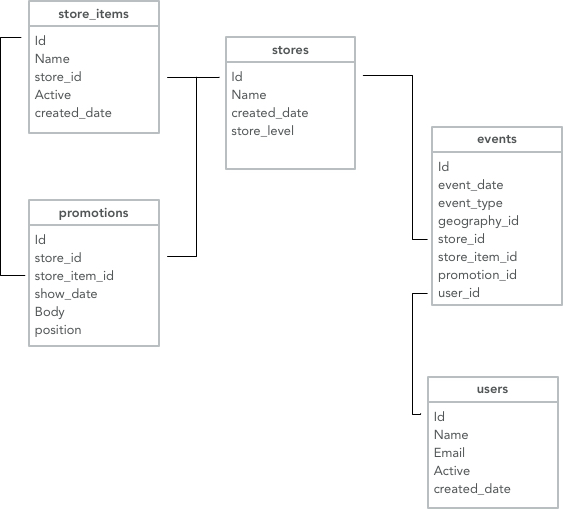

In [44]:
from IPython.display import Image
Image(filename='/Users/benjarman/Development/SparkIpython/data/original_schema.jpg')

Above is the current schema. Right away it's pretty clear this needs some clean up. First of all the whole circular relationships between store_items, stores and promotions is a clear problem. The Other big problem I see is how users ends up being it's own little leg. 

My original solution during the interview was to have events at the center of our star schema. Now that I can see the whole picture it makes allot more since to have stores be the center.

I'm not going to model the whole thing out because it's late and I'm losing steam, but I'll briefly describe my fixes to this.

1. I would denormalize promotions such that it had no relationship to store_items
2. I would denormalize users such that it went directly to stores instead of events
3. I would create some aditional tables for the lookups that were happening between users and events.
4. The events table needs to be broken up into multiple tables. It contains events only related to stores and events only related to users. Seems like a bad design.

My final thought is it's really hard to design a schema like this without knowing the data access paths. Maybe given some use cases making users the center of the schema makes since.